# Polaires

## Imports and base functions

In [2]:
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numba import njit
import pandas as pd
import os
from numba import jit

%matplotlib inline

C:\Users\barroisl\AppData\Local\Temp\ipykernel_13368\3735118499.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]
    
def get_date_time_dif(start_time,stop_time):
    date = date_creator(1, 1, 1)
    datetime1 = datetime.combine(date, start_time)
    datetime2 = datetime.combine(date, stop_time)
    time_elapsed = datetime1 - datetime2
    return time_elapsed.total_seconds()

@njit
def compute_dist(lat1,lon1,lat2,lon2,rad=True):
    if not(rad):
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
    # approximate radius of earth in m
    R = 6373_000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
def remove_zero_from_alti(alti):
    if alti[0] < 10 :
        alti[0] = alti[1]
    if alti[-1] < 10 :
        alti[-1] = alti[-2]
    for i,alt in enumerate(alti):
        if alt < 10 :
            if i >= len(alti)-1 :
                alti[i] = (alti[i-1]+alti[i])/2
            else :  
                alti[i] = (alti[i-1]+alti[i+1])/2
    return alti

def read_igc(file):
    with open(file, 'r') as f:
        parsed_igc_file = Reader().read(f)
    # print('igc_file created')
    previous_lat = 0
    previous_lon = 0
    
    all_lon = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_lat = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_speed=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_vz=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_alti=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_time=[0 for _ in range(len(parsed_igc_file['fix_records'][1]))]

    for i,record in enumerate(parsed_igc_file['fix_records'][1]):
        record['time'] = record['time'].replace(hour=record['time'].hour + 1)
        all_lat[i] = record['lat']
        all_lon[i] = record['lon']
        if previous_lon ==0 :
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']
            all_time[i] = record['time']
        else :
            dxy = abs(compute_dist(previous_lat,previous_lon,record['lat'],record['lon'],rad=False))
            # dz = previous_alt_baro-record['pressure_alt']
            dz = previous_alt_gps-record['gps_alt']
            dt = get_date_time_dif(record['time'],previous_datetime)
            # if dt>2 : print('dtttttt>2 ',dt)
            if dt>0 :
                all_speed[i] = min(100,dxy/dt*3.6)
                all_vz[i] = dz/dt
            all_alti[i] = record['gps_alt']
            all_time[i] = record['time']
            
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']

            # if previous_datetime.hour>10 :
            #     all_speed = all_speed[:i]
            #     all_vz = all_vz[:i]
            #     all_alti = all_alti[:i]
            #     break
#    return all_lon,all_lat,all_speed,all_vz,remove_zero_from_alti(all_alti),all_time
    return all_lon,all_lat,all_alti,all_time

def reshape_array(arr,time_vid):
    nb_img_by_sec = 24
    
    t_true = np.linspace(time_vid[0], time_vid[-1], num=len(time_vid), endpoint=True)
    t_inter = np.linspace(time_vid[0], time_vid[-1], num=int(len(time_vid)*nb_img_by_sec/speed_acc), endpoint=True)
    f = interp1d(t_true, arr, kind='cubic')

    return f(t_inter)

def smooth_igc_output(L_all):
    all_ret = []
    for l_val in L_all:
        l_val[0]=l_val[1]#=np.mean(l_val[:int(len(l_val)/10)])
        smoothed = smooth(l_val,50,'hanning')
        all_ret.append(smoothed)
    return all_ret

def plot_smooth_non_smooth(smooth,non_smooth):
    plt.figure(figsize=(18,9))
    plt.plot(non_smooth)
    plt.plot(smooth)
    plt.show()

def get_last_date_of_all_raw_file(path_raw_file):
    delta_time_writing = 20
    all_ending_time = []
    for file in os.listdir(path_raw_file):
        if "_11_" in file :
            time_end = os.path.getmtime(path_raw_file+'\\'+file)
            all_ending_time.append(datetime.fromtimestamp(time_end-delta_time_writing).time())
    return all_ending_time

def convert_time_to_sec(all_time):
    for i in range(len(all_time)):
        all_time[i] = all_time[i].hour*3600 + all_time[i].minute*60 + all_time[i].second
    return np.array(all_time,dtype=np.float32)

In [4]:
from os import listdir
from os.path import isfile, join
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#path = 'IGC_20-08-2023/'
#list_files = [path+f for f in listdir(path) if isfile(join(path, f))]
list_files = [f for f in listdir(path) if isfile(join(path, f))]

print(len(list_files))

72


In [5]:
@njit
def vz_(all_alti,all_time):
    n = len(all_alti)
    vz = np.zeros((1,n))
    datetime1 = all_time[0]
    for i in range(n-1):
        datetime2 = all_time[i+1]
        dz = all_alti[i+1] - all_alti[i]
        dt = datetime2 - datetime1
        if dt > 0 :
            vz[0,i]=dz/dt
        datetime1 = datetime2
    vz[0,n-1]=vz[0,n-2]
    return vz[0]

@njit
def vh_(all_lon,all_lat,all_time):
    n = len(all_lon)
    vh = np.zeros((1,n))[0]
    datetime1 = all_time[0]
    for i in range(n):
        datetime2 = all_time[i+1]
        lat1 = all_lat[i]
        lat2 = all_lat[i+1]
        lon1 = all_lon[i]
        lon2 = all_lon[i+1]
        dt = datetime2 - datetime1
        if dt > 0 :
            dist = compute_dist(lat1,lon1,lat2,lon2,rad=False)
            vh[i] = dist/dt
        else :
            vh[i] = vh[i-1]
        datetime1 = datetime2
    vh[n-1]=vh[n-2]
    return vh

In [6]:
file = '2023-08-20-XCT-BLA-01.igc'
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#all_lon,all_lat,speed_vid,vz_vid,alti_vid,time_vid,all_vz2,all_speed_smooth, all_vz_smooth, all_alti_smooth,all_alti = prep_file(path, file)
all_lon,all_lat,all_alti,all_time = read_igc(join(path,file))
all_time = convert_time_to_sec(all_time)
all_lon = smooth(all_lon, window_len=50,window='hanning')
all_lat = smooth(all_lat, window_len=50,window='hanning')
all_alti = smooth(remove_zero_from_alti(all_alti), window_len=50,window='hanning')

vz_liste = vz_(all_alti,all_time)
vz_smooth = smooth(vz_liste, window_len=20,window='hanning')
vh_liste = vh_(all_lon,all_lat,all_time)
vh_smooth = smooth(vh_liste, window_len=20,window='hanning')

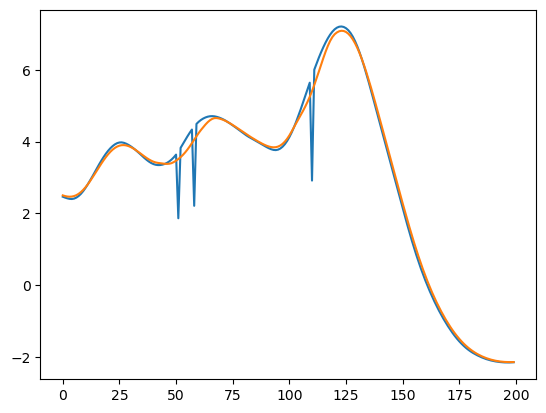

In [17]:
plt.plot(vz_liste[12750:12950])
plt.plot(vz_smooth[12750:12950])

7.08565745932172


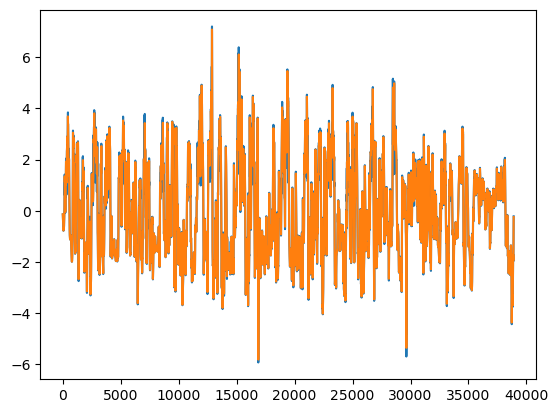

In [8]:
plt.plot(vz_liste)
plt.plot(vz_smooth)
print(np.max(vz_smooth))

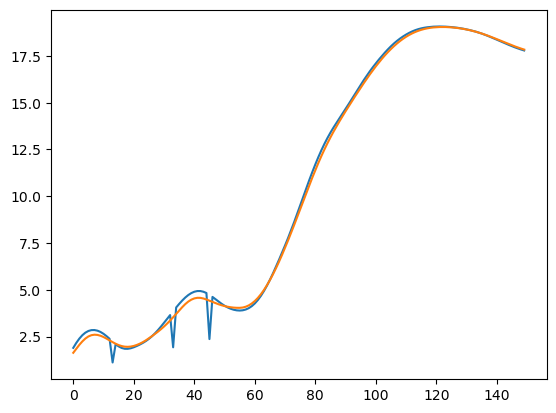

In [11]:
plt.plot(vh_liste[1250:1400])
plt.plot(vh_smooth[1250:1400])

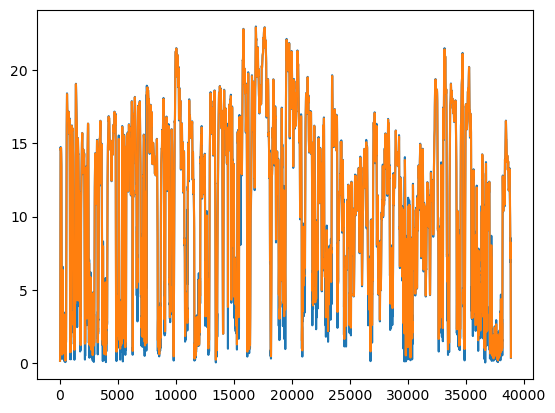

In [10]:
plt.plot(vh_liste)
plt.plot(vh_smooth)

Text(0, 0.5, 'vertical speed')

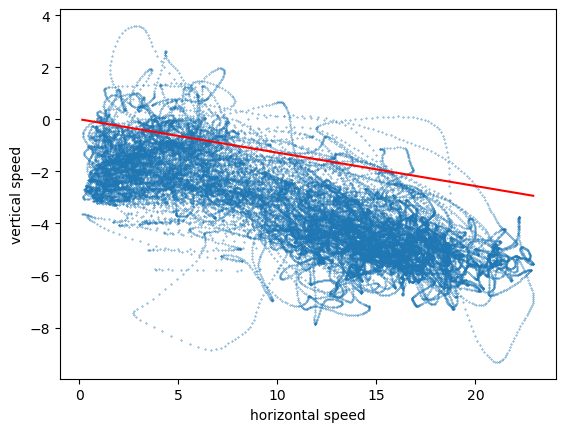

In [68]:
plt.scatter(vh_smooth,vz_smooth-[3.5 for i in range(len(vz_smooth))], s = 0.1)
a = np.linspace(np.min(vh_smooth),np.max(vh_smooth),1000)
plt.plot(a,-(1/7.8)*a,'r')
plt.xlabel('horizontal speed')
plt.ylabel('vertical speed')